In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [5]:
x = np.arange(400,1100 + 100,100)
y = np.arange(250,700 + 50, 50)

In [11]:
X, Y = np.meshgrid(x,y)
boundary = X >= Y + 125
X, Y = X[boundary], Y[boundary]

In [17]:
X.shape

(55,)

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

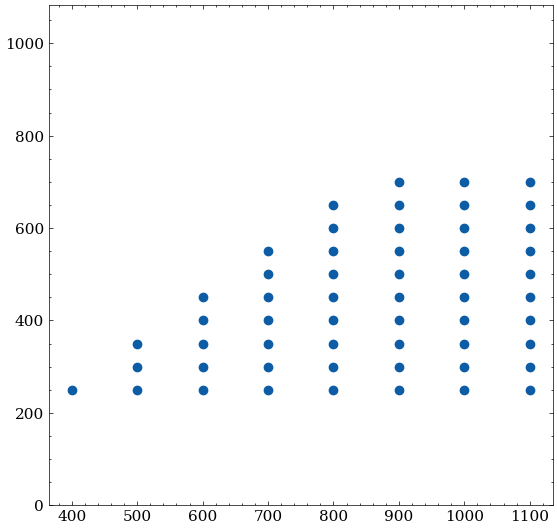

In [16]:
graph_array(X,Y, g_linestyle='none', g_marker='o')

array([ 400,  500,  600,  700,  800,  900, 1000, 1100,  500,  600,  700,
        800,  900, 1000, 1100,  500,  600,  700,  800,  900, 1000, 1100,
        600,  700,  800,  900, 1000, 1100,  600,  700,  800,  900, 1000,
       1100,  700,  800,  900, 1000, 1100,  700,  800,  900, 1000, 1100,
        800,  900, 1000, 1100,  800,  900, 1000, 1100,  900, 1000, 1100])

In [2]:
fname = "/store/user/ekoenig/6BAnalysis/NTuples/2018/feynnet/NMSSM_XYH_YToHH_6b/NMSSM_XToYHTo6B_MX-1000_MY-350_TuneCP5_13TeV-madgraph-pythia8/output/ntuple_0.root"
tree = Tree(fname)

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


In [7]:


tree.write(
    altfile=move_to_debug
)

  0%|          | 0/1 [00:00<?, ?it/s]

Writing root://cmseos.fnal.gov///store/user/ekoenig/6BAnalysis/NTuples/2018/feynnet/NMSSM_XYH_YToHH_6b/NMSSM_XToYHTo6B_MX-1000_MY-350_TuneCP5_13TeV-madgraph-pythia8/debug/ntuple_0.root


[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3010] Opening relative path 'root://cmseos.fnal.gov///store/user/ekoenig/6BAnalysis/NTuples/2018/feynnet/NMSSM_XYH_YToHH_6b/NMSSM_XToYHTo6B_MX-1000_MY-350_TuneCP5_13TeV-madgraph-pythia8/debug/ntuple_0.root?oss.asize=104351787' is disallowed. (destination)

100%|██████████| 1/1 [00:14<00:00, 14.85s/it]


NameError: name 'place_in_loc' is not defined

In [4]:
ak.sum(bkgtree.dataset_norm_abs_scale)

821.2709351319415

In [7]:
eightbpath = "/store/user/ekoenig/8BAnalysis/NTuples/2018/training/sig/*/eightb/split_4_training_ntuple.root"
eightbtrees = ObjIter([ Tree(f) for f in fc.glob(eightbpath) ])

100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


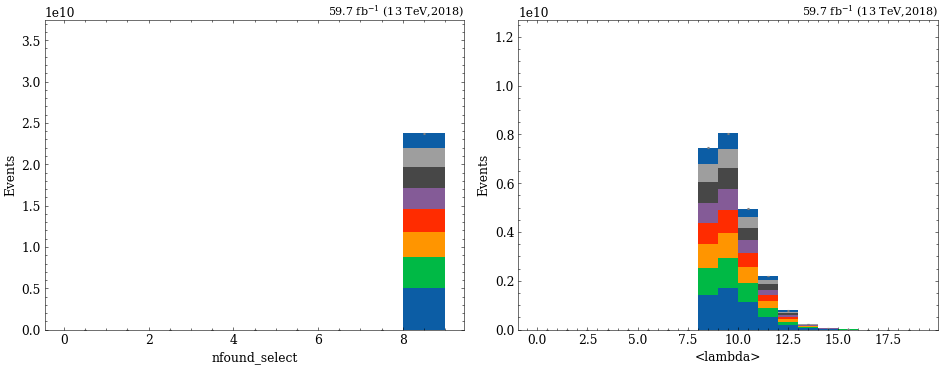

In [8]:
study.quick(
    eightbtrees,
    varlist=['nfound_select', lambda t : ak.count(t.jet_pt,axis=1)]
)

In [9]:
eightbtrees.apply(lambda t : ak.sum(t.dataset_norm_abs_scale))

[821.2709351319406, 821.2709351319412, 821.2709351319406, 821.2709351319409, 821.2709351319409, 821.2709351319409, 821.270935131941, 821.270935131941]

In [2]:
sevenbpath = "/store/user/ekoenig/8BAnalysis/NTuples/2018/training/sig/*/sevenb/split_4_training_ntuple.root"
sevenbtrees = ObjIter([ Tree(f) for f in fc.glob(sevenbpath) ])

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


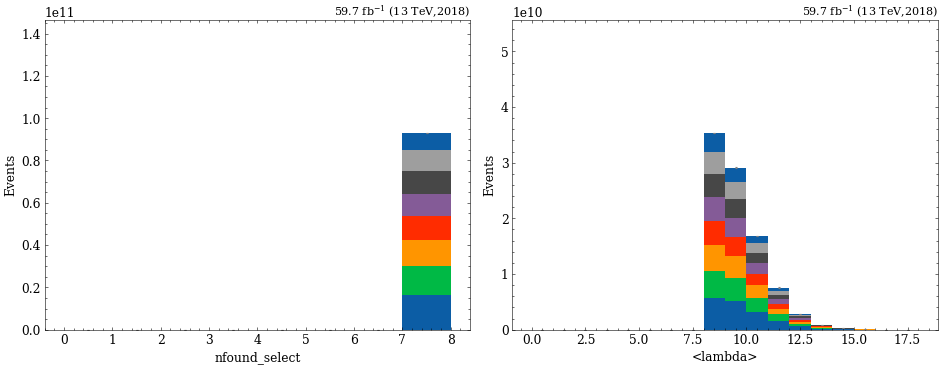

In [5]:
study.quick(
    sevenbtrees,
    varlist=['nfound_select', lambda t : ak.count(t.jet_pt,axis=1)]
)

In [12]:
sevenbtrees.apply(lambda t : ak.sum(t.dataset_norm_abs_scale))

[821.2709351319406, 821.2709351319409, 821.2709351319411, 821.2709351319409, 821.2709351319411, 821.270935131941, 821.2709351319407, 821.270935131941]

In [13]:
sixbpath = "/store/user/ekoenig/8BAnalysis/NTuples/2018/training/sig/*/sixb/training_ntuple.root"
sixbtrees = ObjIter([ Tree(f) for f in fc.glob(sixbpath) ])

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


In [14]:
sixbtrees.apply(lambda t : ak.sum(t.dataset_norm_abs_scale))

[821.2709351319409, 821.2709351319411, 821.2709351319412, 821.2709351319409, 821.2709351319407, 821.2709351319409, 821.2709351319411, 821.2709351319411]

100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


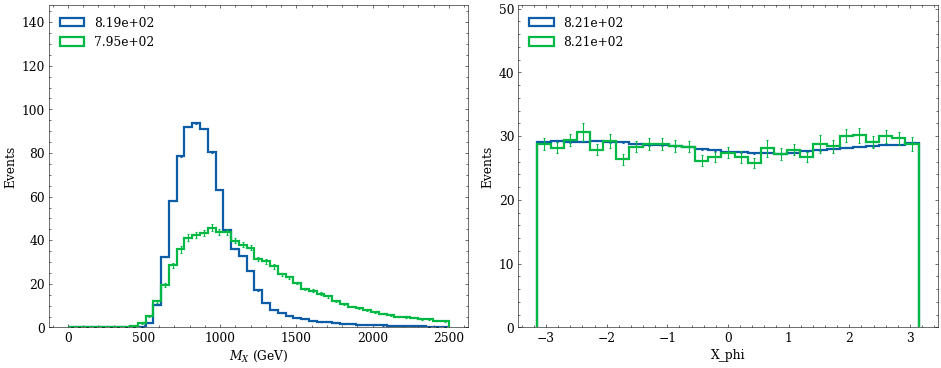

In [30]:
study.quick_region(
    eightbtrees+sevenbtrees,[bkgtree],
    legend=True,
    varlist=['X_m','X_phi'],
    binlist=[(0,2500,50)],
    scale=lambda t : ak.where(t.is_bkg, 1, 1/16.0) * t.dataset_norm_abs_scale/t.scale,
    lumi=None
)